- F검정 (분산분석, ANOVA)
  - 3개 이상의 집단간 평균의 차이를 구할때 사용. (2개도 사용은 가능, 독립표본 T검정과 동일한 결과)
  - 주요 목표는 두 가지 이상의 집단간의 평균이 서로 같은지만 분석 가능
    - 같은지 다른지만 판단 가능하므로 T검정같이 단측검정은 사용할 수 없음

- 일원분산분석 : 요인이 1개
  - ex) 상권별 매출 분석
- 이원분산분석 : 요인이 2개 이상
  - ex) 상권별 상반기/하반기 매출 분석

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

In [5]:
df = pd.read_excel("./data/store.xlsx")
df.head()

,store1,store2
0,34,63
1,63,85
2,57,75
3,50,48
4,37,58


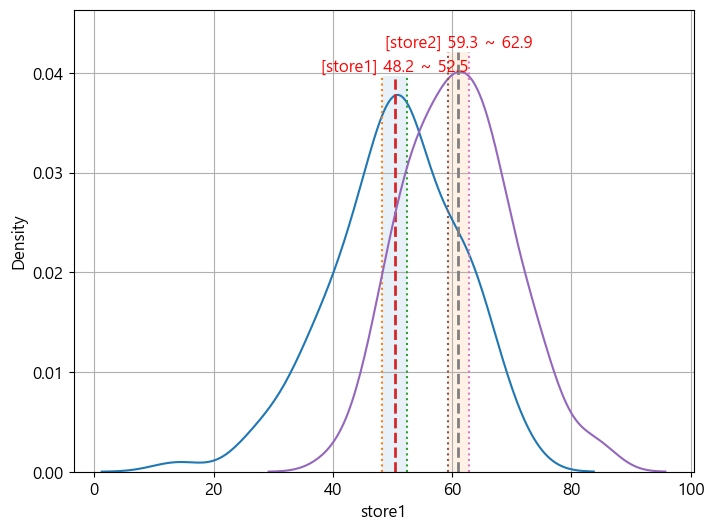

In [8]:
plt.figure()

for c in df.columns:
    #print(c)

    data = df[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [10]:
for c in df.columns:
    s, p = normaltest(df[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[store1] statistic: 5.651, p-value: 0.059, 정규성 충족 여부: True
[store2] statistic: 1.174, p-value: 0.556, 정규성 충족 여부: True


In [11]:
normal_dist = True      # 정규성 만족 여부
data = df.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 2.844, p-value: 0.092, 등분산성 충족 여부: True


- 일원분산분석 (1) : scipy의 f_oneway
  - F검정의 귀무가설 : 모든 집단의 평균은 다르지 않다.
  - 대립가설 : 최소 한 집단의 평균은 다르다.

In [12]:
s, p = f_oneway(df['store1'], df['store2'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

- 일원분산분석(2) : statsmodels의 anova
  - 모든 분산분석은 raw 데이터 형태로 가공하여 사용

In [14]:
df_2 = pd.melt(df, var_name='store', value_name='sales')
df_2.head()

,store,sales
0,store1,34
1,store1,63
2,store1,57
3,store1,50
4,store1,37


- statsmodels의 독립/종속변수 표현식 : '(종속변수) ~ (독립변수) (+로 엮음)'
  - 독립변수에 명목형 변수가 있을 경우 C(변수)로 표기

In [18]:
lm = ols('sales ~ C(store)', data=df_2).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(store),1.0,5735.205,5735.205000,58.717529,7.945482e-13
Residual,198.0,19339.550,97.674495,NaN,NaN


- F : 검정통계량
- PR(>F) : p-value

In [65]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     58.72
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           7.95e-13
Time:                        10:28:37   Log-Likelihood:                -740.95
No. Observations:                 200   AIC:                             1486.
Df Residuals:                     198   BIC:                             1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             50.3600      0.988     50.956      0.000      48.411      52.309
C(store)[T.store2]    10.7100      1.398      7.663      0.000       7.954      13.466
==============================================================================
Omnibus:                        2.899   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.491
Skew:                          -0.224   Prob(JB):                        0.288
Kurtosis:                       3.312   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 58.718, p-value: 0.000, 대립가설 채택'

- 사후검정 : F검정의 결과에 따라 두 집간간 유의미한 차이가 발견되었을 때 구체적으로 어떤 차이가 있는지 확인
  - 귀무가설 : 집단간 분산이 차이가 없다
  - 대립가설 : 집간간 분산의 차이가 있다

- 사후검정
  - 투키 HSD : 등분산 + 샘플수가 동일
  - 본페로니, (피셔, 셰페) : 등분산이며 샘플수가 다름
    - 피셔, 셰페방법은 검정력이 약해 잘 쓰이지 않음
  - Games Howell : 등분산이 아닌경우

- 투키 HSD
  - 등분산을 만족하고 샘플수가 동일할 때 사용
  - 파라미터 alpha : 유의수준

In [33]:
?pairwise_tukeyhsd

Signature: pairwise_tukeyhsd(endog, groups, alpha=0.05)
Docstring:
Calculate all pairwise comparisons with TukeyHSD confidence intervals

Parameters
----------
endog : ndarray, float, 1d
    response variable
groups : ndarray, 1d
    array with groups, can be string or integers
alpha : float
    significance level for the test

Returns
-------
results : TukeyHSDResults instance
    A results class containing relevant data and some post-hoc
    calculations, including adjusted p-value

Notes
-----
This is just a wrapper around tukeyhsd method of MultiComparison

See Also
--------
MultiComparison
tukeyhsd
statsmodels.sandbox.stats.multicomp.TukeyHSDResults
File:      c:\users\yjg10\anaconda3\lib\site-packages\statsmodels\stats\multicomp.py
Type:      function

In [41]:
tukey = pairwise_tukeyhsd(df_2['sales'], df_2['store'], alpha = 0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
store1,store2,10.71,0.0,7.9538,13.4662,True


- p-adj : p-value
- meandiff : 두 집단간 평균 차이
  - 기준은 뒤쪽 (group2가 더 높으면 양수)
- lower, upper : 95% 신뢰구간의 범위

- 본페로니 교정
  - 등분산 만족하나 샘플수가 다를 때 사용
  - MultiComparison의 allpairtest로 실행
    - 첫번째 파라미터로 독립표본 T검정 함수
    - method 파라미터를 'bonf'로 하면 본페로니 교정 설정 (default)
    - alpha 파라미터 : 유의수준

In [42]:
?MultiComparison

Init signature: MultiComparison(data, groups, group_order=None)
Docstring:     
Tests for multiple comparisons

Parameters
----------
data : ndarray
    independent data samples
groups : ndarray
    group labels corresponding to each data point
group_order : list[str], optional
    the desired order for the group mean results to be reported in. If
    not specified, results are reported in increasing order.
    If group_order does not contain all labels that are in groups, then
    only those observations are kept that have a label in group_order.
File:           c:\users\yjg10\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py
Type:           type
Subclasses:     

In [43]:
?comp.allpairtest

Signature: comp.allpairtest(testfunc, alpha=0.05, method='bonf', pvalidx=1)
Docstring:
run a pairwise test on all pairs with multiple test correction

The statistical test given in testfunc is calculated for all pairs
and the p-values are adjusted by methods in multipletests. The p-value
correction is generic and based only on the p-values, and does not
take any special structure of the hypotheses into account.

Parameters
----------
testfunc : function
    A test function for two (independent) samples. It is assumed that
    the return value on position pvalidx is the p-value.
alpha : float
    familywise error rate
method : str
    This specifies the method for the p-value correction. Any method
    of multipletests is possible.
pvalidx : int (default: 1)
    position of the p-value in the return of testfunc

Returns
-------
sumtab : SimpleTable instance
    summary table for printing

errors:  TODO: check if this is still wrong, I think it's fixed.
results from multipletests are in 

In [46]:
comp = MultiComparison(df_2['sales'], df_2['store'])
result = comp.allpairtest(ttest_ind, method='bonf', alpha = 0.05)
result[0]

group1,group2,stat,pval,pval_corr,reject
store1,store2,-7.6627,0.0,0.0,True


- p-val : p-value이나 교정된 p-value (pval_corr)로 검정 결과 해석

- Games-Howell 검정
  - 등분산 만족하지 않을 경우 사용
  - diff 부호 기준이 Tukey와 반대

In [47]:
?pairwise_gameshowell

Signature: pairwise_gameshowell(data=None, dv=None, between=None, effsize='hedges')
Docstring:
Pairwise Games-Howell post-hoc test.

Parameters
----------
data : :py:class:`pandas.DataFrame`
    DataFrame
dv : string
    Name of column containing the dependent variable.
between: string
    Name of column containing the between factor.
effsize : string or None
    Effect size type. Available methods are:

    * ``'none'``: no effect size
    * ``'cohen'``: Unbiased Cohen d
    * ``'hedges'``: Hedges g
    * ``'r'``: Pearson correlation coefficient
    * ``'eta-square'``: Eta-square
    * ``'odds-ratio'``: Odds ratio
    * ``'AUC'``: Area Under the Curve
    * ``'CLES'``: Common Language Effect Size

Returns
-------
stats : :py:class:`pandas.DataFrame`
    Stats summary:

    * ``'A'``: Name of first measurement
    * ``'B'``: Name of second measurement
    * ``'mean(A)'``: Mean of first measurement
    * ``'mean(B)'``: Mean of second measurement
    * ``'diff'``: Mean difference (= mean

In [61]:
result = pairwise_gameshowell(df_2, dv='sales', between='store')
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,store1,store2,50.36,61.07,-10.71,1.397673,-7.662736,192.521085,9.281464e-13,-1.079565


In [27]:
df2 = pd.read_excel("./data/commercial.xlsx")
df2.head()

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


In [28]:
df2_2 = df2[['type', 'sales_amount']]
df2_2.head()

,type,sales_amount
0,관광특구,72523644100
1,관광특구,283332346393
2,관광특구,81696730221
3,관광특구,212062656625
4,관광특구,231338386876


In [30]:
comp = MultiComparison(df2_2['sales_amount'], df2_2['type'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
골목상권,관광특구,-113.3793,0.0,0.0,True
골목상권,발달상권,-32.8487,0.0,0.0,True
골목상권,전통시장,-20.0738,0.0,0.0,True
관광특구,발달상권,7.9803,0.0,0.0,True
관광특구,전통시장,41.4036,0.0,0.0,True
발달상권,전통시장,14.6423,0.0,0.0,True


In [31]:
tukey = pairwise_tukeyhsd(df2_2['sales_amount'], df2_2['type'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
골목상권,관광특구,224483682342.9824,0.0,201855425195.959,247111939490.0059,True
골목상권,발달상권,53403587792.8906,0.0,49498301752.789,57308873832.9922,True
골목상권,전통시장,6924689176.0977,0.0,3182845037.2924,10666533314.9031,True
관광특구,발달상권,-171080094550.0918,0.0,-193912515404.7516,-148247673695.4321,True
관광특구,전통시장,-217558993166.8847,0.0,-240364027273.1605,-194753959060.6089,True
발달상권,전통시장,-46478898616.7928,0.0,-51304125878.9636,-41653671354.622,True


In [32]:
result = pairwise_gameshowell(df2_2, dv='sales_amount', between='type')
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509e+09,2.281432e+11,-2.244837e+11,2.289216e+10,-9.806138,23.000501,6.410146e-09,-23.206979
1,골목상권,발달상권,3.659509e+09,5.706310e+10,-5.340359e+10,3.282878e+09,-16.267309,996.054989,7.271961e-14,-1.160433
2,골목상권,전통시장,3.659509e+09,1.058420e+10,-6.924689e+09,6.060559e+08,-11.425826,1143.188337,0.000000e+00,-0.679464
3,관광특구,발달상권,2.281432e+11,5.706310e+10,1.710801e+11,2.312611e+10,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,2.281432e+11,1.058420e+10,2.175590e+11,2.289993e+10,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,5.706310e+10,1.058420e+10,4.647890e+10,3.336641e+09,13.929848,1061.849622,3.926859e-13,0.638976


- 이원분산분석
  - 명목형 변수가 2개 이상
  - 2개 이상의 요인에 따른 영향을 확인하고자 하는 것이기 때문에 (교효작용) 사후 검정은 의미가 별로 없다.

In [69]:
df3 = pd.read_excel("./data/head_size.xlsx")
df3.head()

,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


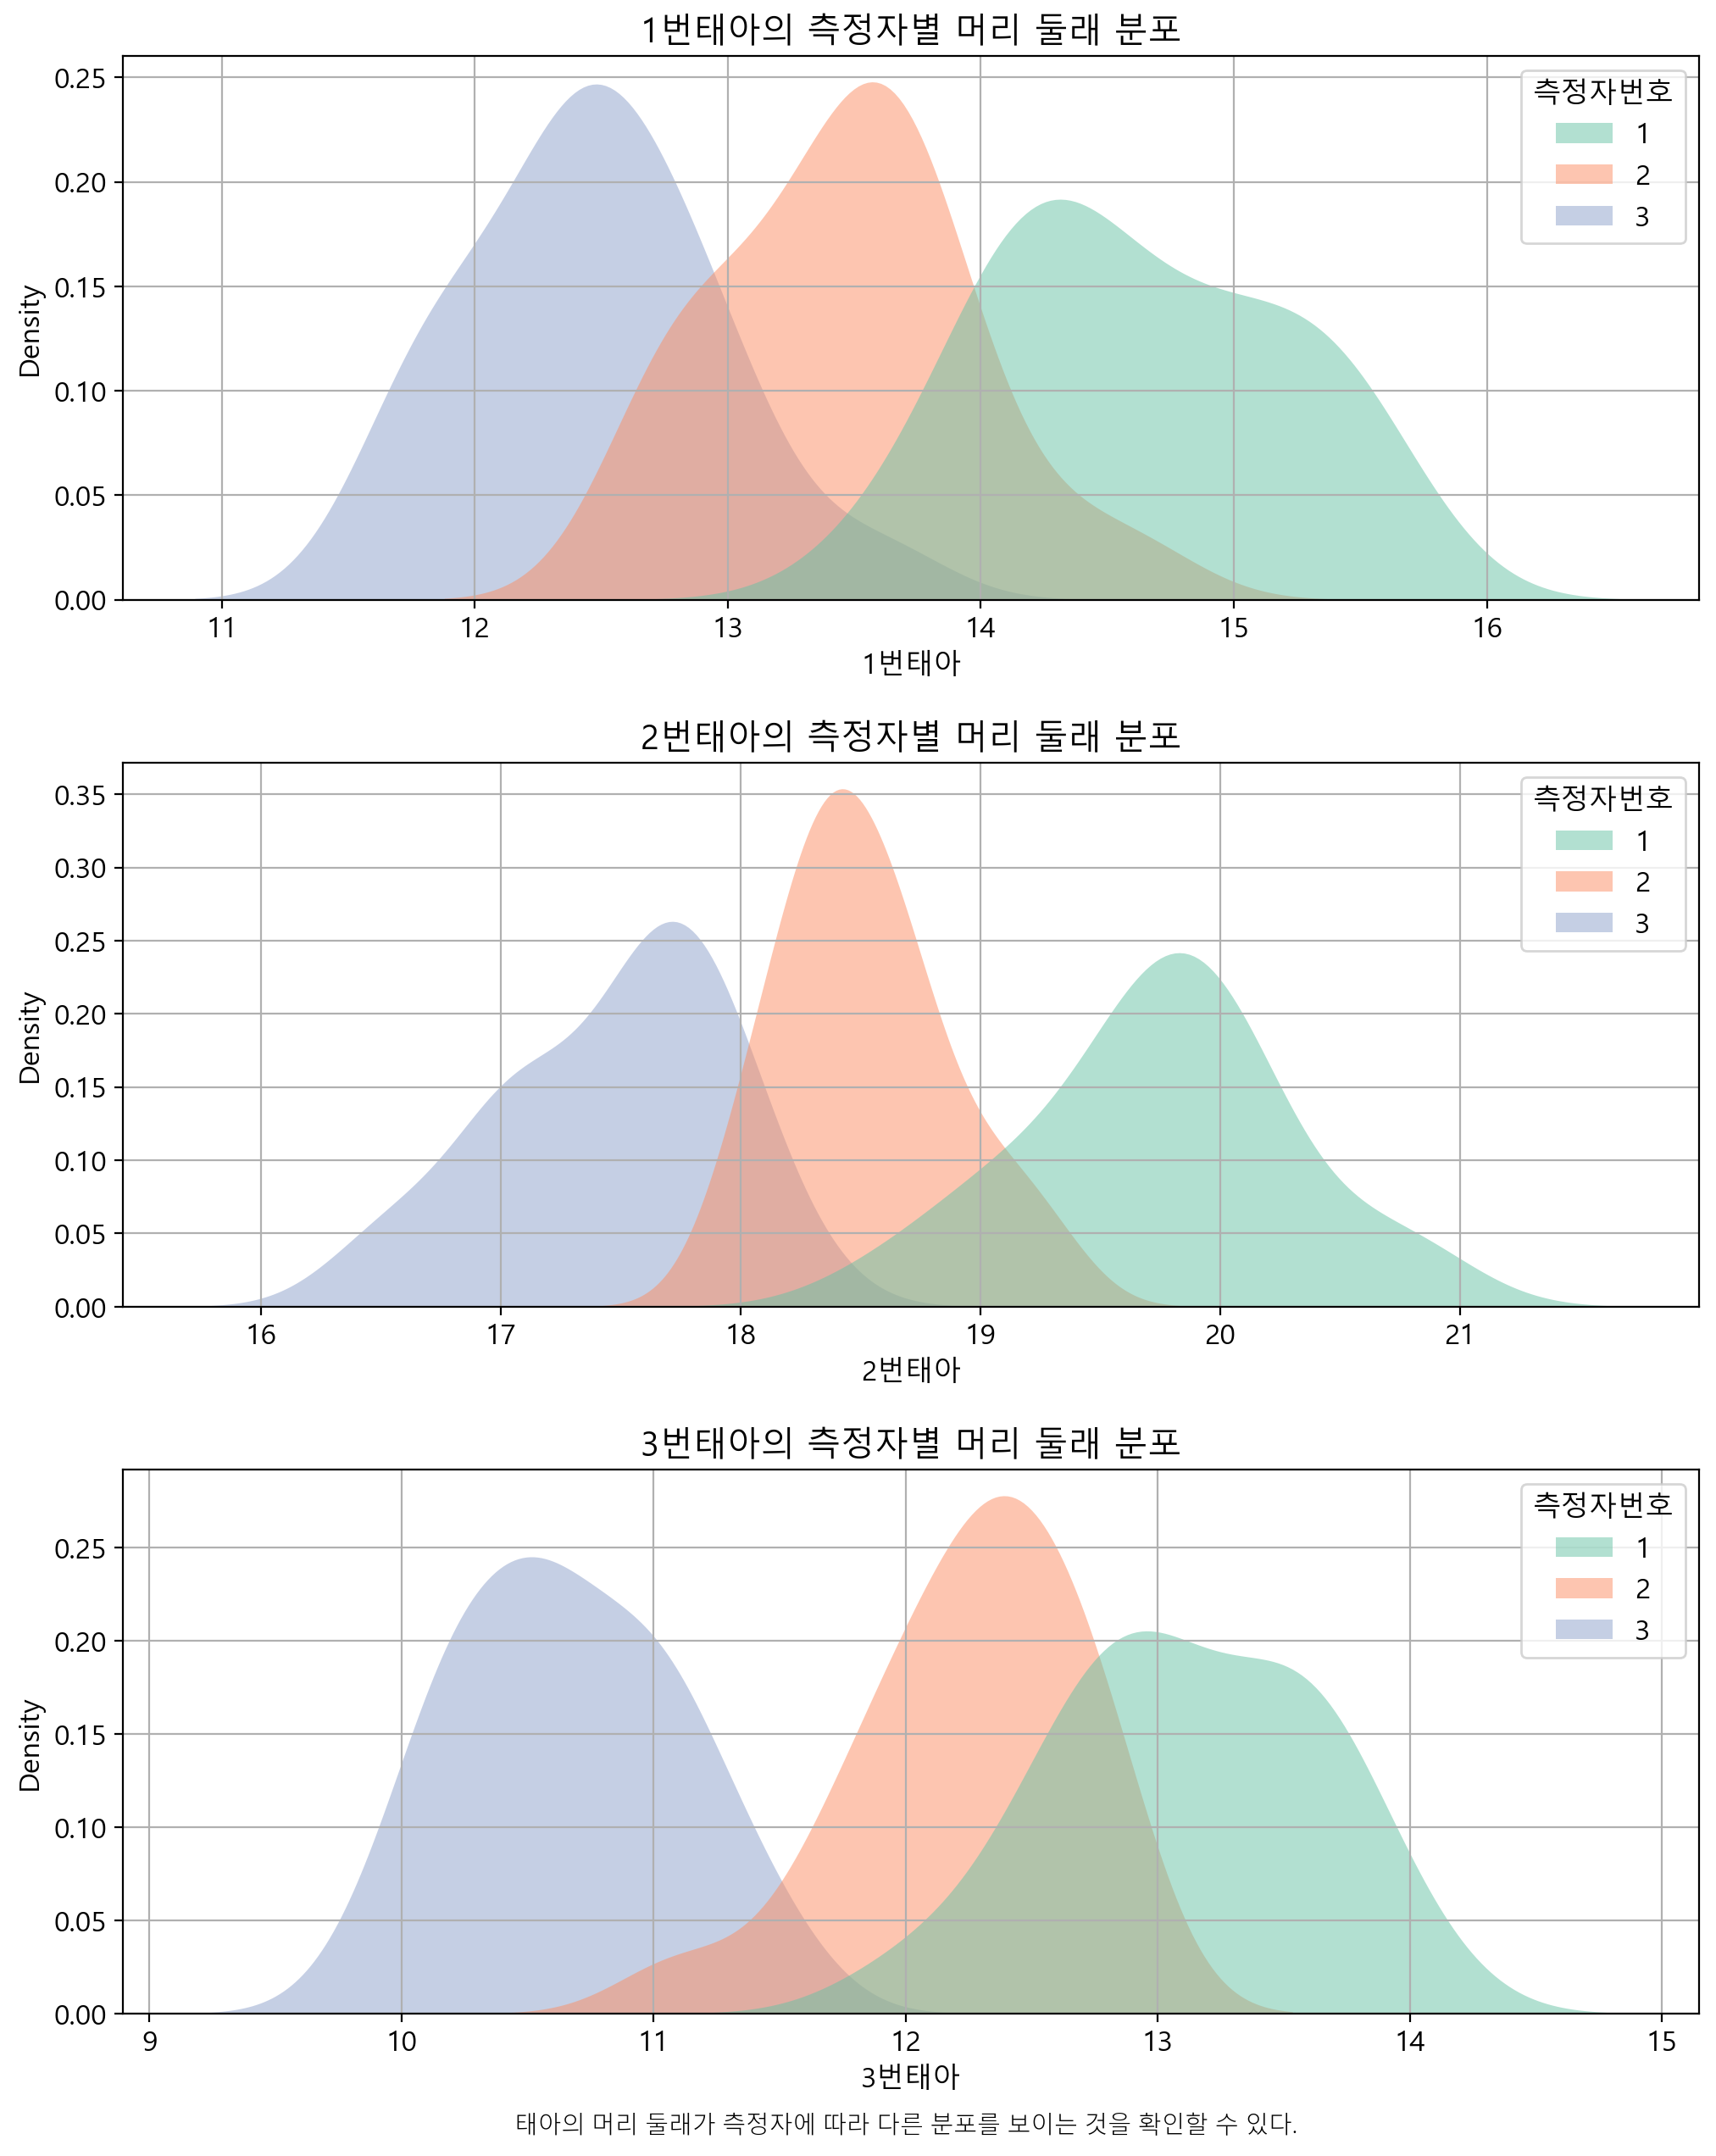

In [70]:
fields = ['1번태아', '2번태아', '3번태아']

fig, ax = plt.subplots(3, 1, figsize=(12, 15), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v, in enumerate(ax):
    sb.kdeplot(data=df3, x=fields[i], hue='측정자번호', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title("%s의 측정자별 머리 둘래 분포" % fields[i])

txt = "태아의 머리 둘래가 측정자에 따라 다른 분포를 보이는 것을 확인할 수 있다."
plt.figtext(0.51, 0.07, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

In [71]:
df3_2 = pd.melt(df3, id_vars='측정자번호',
     value_vars=['1번태아', '2번태아', '3번태아'],
     var_name='태아번호', value_name='머리둘레')
df3_2

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4
...,...,...,...
175,3,3번태아,11.0
176,3,3번태아,10.2
177,3,3번태아,10.1
178,3,3번태아,10.2


In [72]:
측정자번호 = df3_2['측정자번호'].unique()
측정자번호

array([1, 2, 3], dtype=int64)

In [73]:
태아번호 = df3_2['태아번호'].unique()
태아번호

array(['1번태아', '2번태아', '3번태아'], dtype=object)

In [76]:
for i in 측정자번호:
    for j in 태아번호:
        data = df3_2[(df3_2['측정자번호'] == i) & (df3_2['태아번호'] == j)]['머리둘레']
        s, p = normaltest(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p >= 0.05))

[1 + 1번태아] statistic: 1.885, p-value: 0.390, 정규성 충족 여부: True
[1 + 2번태아] statistic: 0.290, p-value: 0.865, 정규성 충족 여부: True
[1 + 3번태아] statistic: 0.409, p-value: 0.815, 정규성 충족 여부: True
[2 + 1번태아] statistic: 0.455, p-value: 0.797, 정규성 충족 여부: True
[2 + 2번태아] statistic: 1.443, p-value: 0.486, 정규성 충족 여부: True
[2 + 3번태아] statistic: 3.862, p-value: 0.145, 정규성 충족 여부: True
[3 + 1번태아] statistic: 0.667, p-value: 0.716, 정규성 충족 여부: True
[3 + 2번태아] statistic: 1.463, p-value: 0.481, 정규성 충족 여부: True
[3 + 3번태아] statistic: 0.847, p-value: 0.655, 정규성 충족 여부: True


In [77]:
fields = []

for i in 측정자번호:
    for j in 태아번호:
        data = df3_2[(df3_2['측정자번호'] == i) & (df3_2['태아번호'] == j)]['머리둘레']
        fields.append(data)

s, p = bartlett(*fields)
print("statistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05))

statistic: 6.132, p-value: 0.632, 등분산성 충족 여부: True


- R 표현식 : 각 변수를 +로 엮어서 나열, 변수끼리 묶어 영향을 확인할 때는 :로 묶음 (1개로 취급)
  - 모든 조합을 확인하려면 *로 묶으면 됨 (단일 + 합산)

In [78]:
#formula = '머리둘레 ~ C(태아번호)+C(측정자번호)+C(태아번호):C(측정자번호)'
formula = '머리둘레 ~ C(태아번호)*C(측정자번호)'
lm = ols(formula, df3_2).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(태아번호),2.0,1422.825444,711.412722,3008.013241,5.616407e-134
C(측정자번호),2.0,159.320778,79.660389,336.822068,4.904107e-60
C(태아번호):C(측정자번호),4.0,2.201222,0.550306,2.326816,5.827850e-02
Residual,171.0,40.442500,0.236506,NaN,NaN


In [80]:
df4 = pd.read_excel("./data/plant_growth.xlsx")
df4.head()

,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


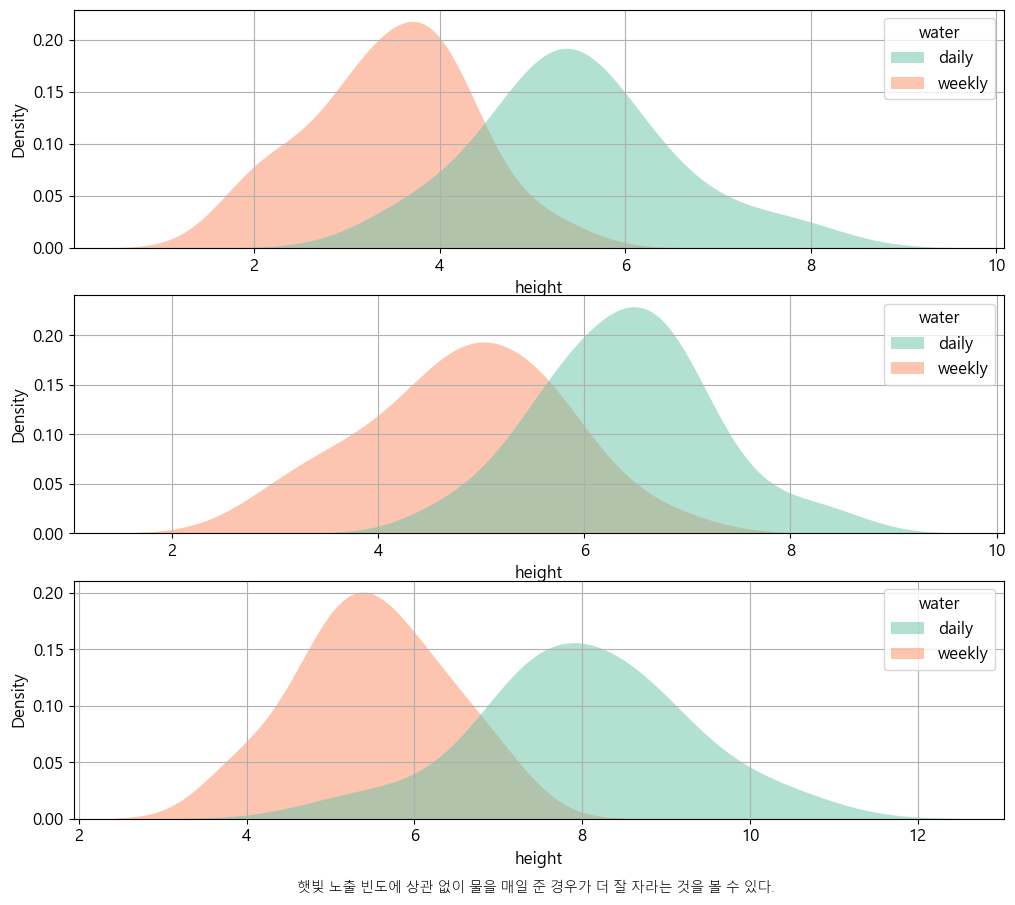

In [81]:
sun = df4['sun'].unique()
s = len(sun)

fig, ax = plt.subplots(s, 1, figsize=(12, 3.5*s))

for i, v in enumerate(ax):
    data = df4[df4['sun'] == sun[i]]
    sb.kdeplot(data=data, x='height', hue='water', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()

txt = """햇빛 노출 빈도에 상관 없이 물을 매일 준 경우가 더 잘 자라는 것을 볼 수 있다."""

plt.figtext(0.51, 0.05, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

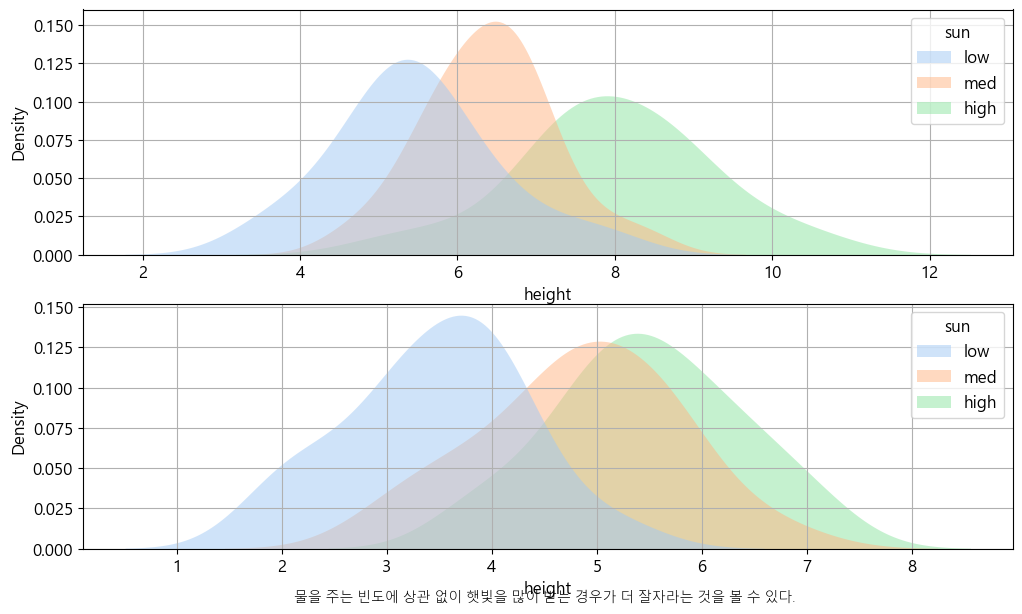

In [82]:
water = df4['water'].unique()
s = len(water)

fig, ax = plt.subplots(s, 1, figsize=(12, 3.5*s))

for i, v in enumerate(ax):
    data = df4[df4['water'] == water[i]]
    sb.kdeplot(data=data, x='height', hue='sun', palette='pastel',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()

txt = """물을 주는 빈도에 상관 없이 햇빛을 많이 받는 경우가 더 잘자라는 것을 볼 수 있다."""

plt.figtext(0.51, 0.05, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

In [83]:
water = df4['water'].unique()
sun = df4['sun'].unique()

for i in water:
    for j in sun:
        data = df4[(df4['water'] == i) & (df4['sun'] == j)]['height']
        s, p = normaltest(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p > 0.05))

[daily + low] statistic: 1.462, p-value: 0.482, 정규성 충족 여부: True
[daily + med] statistic: 0.867, p-value: 0.648, 정규성 충족 여부: True
[daily + high] statistic: 0.802, p-value: 0.670, 정규성 충족 여부: True
[weekly + low] statistic: 0.074, p-value: 0.964, 정규성 충족 여부: True
[weekly + med] statistic: 0.161, p-value: 0.923, 정규성 충족 여부: True
[weekly + high] statistic: 0.053, p-value: 0.974, 정규성 충족 여부: True


In [84]:
fields = []

for i in water:
    for j in sun:
        data = df4[(df4['water'] == i) & (df4['sun'] == j)]['height']
        fields.append(data)

s, p = bartlett(*fields)
print("statistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05))

statistic: 4.488, p-value: 0.481, 등분산성 충족 여부: True


In [86]:
?anova_lm

Signature: anova_lm(*args, **kwargs)
Docstring:
Anova table for one or more fitted linear models.

Parameters
----------
args : fitted linear model results instance
    One or more fitted linear models
scale : float
    Estimate of variance, If None, will be estimated from the largest
    model. Default is None.
test : str {"F", "Chisq", "Cp"} or None
    Test statistics to provide. Default is "F".
typ : str or int {"I","II","III"} or {1,2,3}
    The type of Anova test to perform. See notes.
robust : {None, "hc0", "hc1", "hc2", "hc3"}
    Use heteroscedasticity-corrected coefficient covariance matrix.
    If robust covariance is desired, it is recommended to use `hc3`.

Returns
-------
anova : DataFrame
    When args is a single model, return is DataFrame with columns:

    sum_sq : float64
        Sum of squares for model terms.
    df : float64
        Degrees of freedom for model terms.
    F : float64
        F statistic value for significance of adding model terms.
    PR(>F) : fl

In [85]:
formula = 'height ~ C(water)*C(sun)'
lm = ols(formula, df4).fit()
anova = anova_lm(lm, tpy=2)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(water),1.0,122.816333,122.816333,130.528994,1.301312e-20
C(sun),2.0,103.292167,51.646083,54.889371,2.013276e-17
C(water):C(sun),2.0,4.327167,2.163583,2.299453,1.049489e-01
Residual,114.0,107.264000,0.940912,NaN,NaN


- 교효작용 : 독립변수간의 영향이 종속변수에 영향을 주는 것
  - 교효작용에 의한 영향이 적다는 것은 상호작용이 영향을 주는 것이 아닌것 (시너지 작용이 없다)
  - A가 양의 관계, B가 양의 관계라고 해서 A가 많다고 B가 적어져도 괜찮다는 것이 아님